In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator

import feather

from tqdm import tqdm_notebook as tqdm

from tqdm import tqdm_pandas

from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

from multiprocessing import Pool

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing

from pathlib import Path

# import plaidml.keras

# plaidml.keras.install_backend()

import keras
from keras.preprocessing import sequence
from keras import layers, Input, Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, LSTM, Dropout

import tensorflow as tf

import glob

import re

Using TensorFlow backend.


## Loading and setting up the data

In [148]:
se = feather.read_dataframe("../../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_dwell.feather",
                            columns=["index",
                                     "segment_duration",
                                     "mean_durations_by_segment_code",
                                     "mean_durations_by_segment_code_and_hour_and_day",
                                     "diff_segment_and_mean_by_segment_code",
                                     "diff_segment_and_mean_by_segment_code_and_hour_and_day",
                                     'line_distance',
                                     'to_centre_dist',
                                     'direction_degrees',
                                     'rain',
                                     'median_durations_by_segment_code_and_hour_and_day',
                                     'arrival_hour','arrival_day',
                                     "diff_percent_segment_and_mean_by_segment_code_and_hour_and_day",
                                     'date','workid',
                                     'actualArrival',
                                     'publicName'
                                    ])
se = se.set_index(se.columns[0])

In [149]:
 # And now for just segments:
se["diff_segment_and_mean_by_segment_code"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code"]
)
se["diff_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code_and_hour_and_day"]
)

se["diff_percent_segment_and_mean_by_segment_code"] = (
    se["diff_segment_and_mean_by_segment_code"]
    * 100
    / se["mean_durations_by_segment_code"]
)

se["diff_percent_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["diff_segment_and_mean_by_segment_code_and_hour_and_day"]
    * 100
    / se["mean_durations_by_segment_code_and_hour_and_day"]
)

## Settings

In [4]:
data_size = 2000000
data_mask = np.zeros(se.shape[0]).astype(bool)

data_mask[:data_size] = True

train = False
test = False

if train:
    data_mask = se['train']
    
if test: 
    data_mask = se['test']

data_size = np.count_nonzero(data_mask)


In [8]:
def calc_slice(width, time, width_offset=0, time_offset=0, additional_prev=0):
    centre = int(len(width_array)/2) + 1
    centre += width_offset
    
    return np.s_[:,2+time_offset:time+3+time_offset,centre-width-additional_prev:centre+width+1]


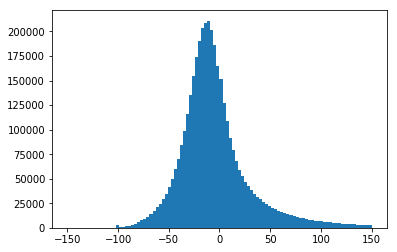

In [7]:
plt.hist(se['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'], bins=100, range=(-150,150));

In [ ]:
# 1st Dimension is length of data points
# 2nd dimension is going back in time
# 3rd dimention is prev-next




In [6]:
def load_matrices(filename):
    # st_offsets_dense = np.load("st_offsets_dense(2,10)_t_off(0,11)_w_off(-5,6).npy")
    st_offsets_dense = np.load(filename)

    bus_counts = np.load("bus_counts(2,10).npy")
    offsets_sparse2 = np.load("offsets_sparse2(10,20).npy")
    # st_offsets_dense_plus_prev = np.load("st_offsets_dense(2,10)_t_off(0,11)_w_off(-5,6)_1prev.npy")
    offsets_dense2 = st_offsets_dense[:,0,int((st_offsets_dense.shape[2]-1)/2)]
    
    st_offsets_dense = st_offsets_dense[:data_size]
    offsets_dense2 = offsets_dense2[:data_size]
    
    offsets_sparse2_big = np.empty(st_offsets_dense.shape)

    offsets_sparse2_big[:] = offsets_sparse2[:,None,None]

    st_offsets_dense_replaced = st_offsets_dense.copy()

    st_offsets_dense_replaced[st_offsets_dense_replaced == 0] = offsets_sparse2_big[st_offsets_dense_replaced == 0]
    
    st_offsets_dense_replaced_diffs = st_offsets_dense_replaced - offsets_sparse2_big

    offsets_sparse2_big = None
    
    fraction_nonzero = np.count_nonzero(st_offsets_dense)/st_offsets_dense.size
    
    return st_offsets_dense, bus_counts, offsets_sparse2, offsets_dense2, st_offsets_dense_replaced, st_offsets_dense_replaced_diffs, fraction_nonzero


In [82]:
st_offsets_dense, bus_counts, offsets_sparse2, offsets_dense2, st_offsets_dense_replaced, st_offsets_dense_replaced_diffs, fraction_nonzero = load_matrices("st_offsets_dense(2,10)_t_off(0,11)_w_off(-5,6).npy")

In [83]:
print(f"Percent nonzero:{np.count_nonzero(st_offsets_dense)/st_offsets_dense.size}")

Percent nonzero:0.39551788842975205


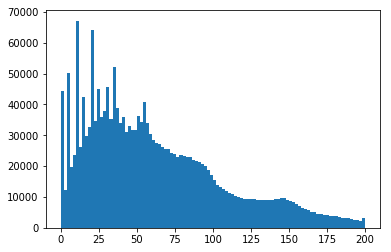

In [84]:
plt.hist(bus_counts, bins=100, range=(0,200));

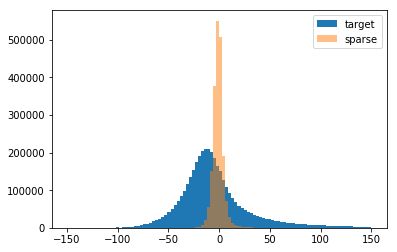

In [85]:
plt.hist(se['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'], bins=100, range=(-150,150), label="target");
plt.hist(offsets_sparse2, bins=100, range=(-150,150), label="sparse", alpha=0.5);
plt.legend()

In [119]:
high_low_size = 10000
bus_count_min = 200

In [120]:
median_target = np.median(se['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'].values)

bottom_10, top_10 = np.quantile(se['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'].values, (.1,.9))

sparse_high = offsets_sparse2[(se[data_mask]['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] > median_target) & (bus_counts > bus_count_min)]
sparse_low = offsets_sparse2[(se[data_mask]['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] < median_target) & (bus_counts > bus_count_min)]

sparse_vhigh = offsets_sparse2[(se[data_mask]['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] > top_10) & (bus_counts > bus_count_min)]
sparse_vlow = offsets_sparse2[(se[data_mask]['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] < bottom_10) & (bus_counts > bus_count_min)]

In [121]:
dense_high = st_offsets_dense[(se[data_mask]['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] > median_target) & (bus_counts > bus_count_min)]
dense_low = st_offsets_dense[(se[data_mask]['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] < median_target) & (bus_counts > bus_count_min)]

dense_vhigh = st_offsets_dense[(se[data_mask]['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] > top_10) & (bus_counts > bus_count_min)]
dense_vlow = st_offsets_dense[(se[data_mask]['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] < bottom_10) & (bus_counts > bus_count_min)]


In [122]:
dense2_high = offsets_dense2[(se[data_mask]['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] > median_target) & (bus_counts > bus_count_min)]
dense2_low = offsets_dense2[(se[data_mask]['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] < median_target) & (bus_counts > bus_count_min)]

dense2_vhigh = offsets_dense2[(se[data_mask]['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] > top_10) & (bus_counts > bus_count_min)]
dense2_vlow = offsets_dense2[(se[data_mask]['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] < bottom_10) & (bus_counts > bus_count_min)]


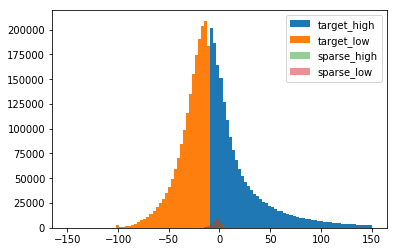

In [123]:
plt.hist(se[se['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] > median_target]['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'], bins=100, range=(-150,150), label="target_high");
plt.hist(se[se['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] < median_target]['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'], bins=100, range=(-150,150), label="target_low");
plt.hist(sparse_high, bins=100, range=(-150,150), label="sparse_high", alpha=0.5);
plt.hist(sparse_low, bins=100, range=(-150,150), label="sparse_low", alpha=0.5);
plt.legend()

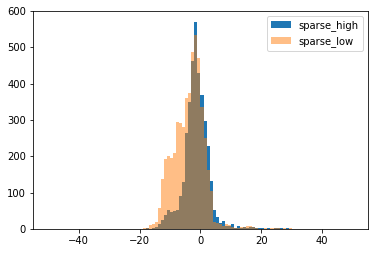

In [124]:
plt.hist(sparse_vhigh, bins=100, range=(-50,50), label="sparse_high")
plt.hist(sparse_vlow, bins=100, range=(-50,50), label="sparse_low", alpha=0.5);
plt.legend()

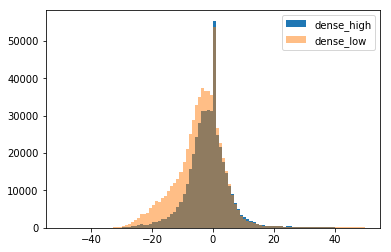

In [136]:
plt.hist(dense_vhigh.ravel(), bins=100, range=(-50,50), label="dense_high")
plt.hist(dense_vlow.ravel(), bins=100, range=(-50,50), label="dense_low", alpha=0.5);
plt.legend()

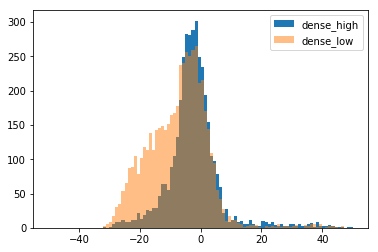

In [134]:
plt.hist(dense2_vhigh.ravel(), bins=100, range=(-50,50), label="dense_high")
plt.hist(dense2_vlow.ravel(), bins=100, range=(-50,50), label="dense_low", alpha=0.5);
plt.legend()

In [127]:
print(f"High mean: {np.mean(sparse_high)}")
print(f"Low mean: {np.mean(sparse_low)}")
print(f"V high mean: {np.mean(sparse_vhigh)}")
print(f"V low mean: {np.mean(sparse_vlow)}")

High mean: -1.7163390362622832
Low mean: -2.6317504819619018
V high mean: -1.4049523794574261
V low mean: -3.7717033120268373


In [128]:
print(f"High mean: {np.mean(dense_high)}")
print(f"Low mean: {np.mean(dense_low)}")
print(f"V high mean: {np.mean(dense_vhigh)}")
print(f"V low mean: {np.mean(dense_vlow)}")

High mean: -1.8487776639633637
Low mean: -2.7479983188115362
V high mean: -1.548968114383464
V low mean: -4.080399979684868


In [129]:
print(f"High mean: {np.mean(dense2_high)}")
print(f"Low mean: {np.mean(dense2_low)}")
print(f"V high mean: {np.mean(dense2_vhigh)}")
print(f"V low mean: {np.mean(dense2_vlow)}")

High mean: -3.0502506994182874
Low mean: -4.584938861175428
V high mean: -2.27525644032066
V low mean: -7.4474312140200905


In [137]:
variances = np.std(st_offsets_dense, axis=(1,2))

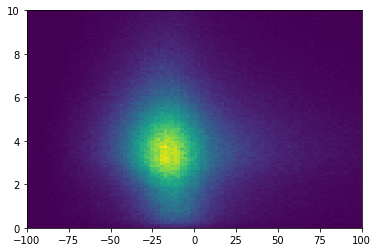

In [146]:
plt.hist2d(se['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'][:data_size][variances != 0], variances[variances != 0], bins=[100,100], range=[[-100,100],[0,10]]);


In [157]:
routes = se[:data_size].reset_index().groupby('publicName')

In [186]:
bus_count_min = 125

names = []
freq = []

sparse_low_mean = []
sparse_high_mean = []
sparse_vlow_mean = []
sparse_vhigh_mean = []

sparse_low_data = []
sparse_high_data = []
sparse_vlow_data = []
sparse_vhigh_data = []

dense_low_mean = []
dense_high_mean = []
dense_vlow_mean = []
dense_vhigh_mean = []

dense_low_data = []
dense_high_data = []
dense_vlow_data = []
dense_vhigh_data = []

for name, route in routes:
#     print(f"{name} x {len(route)}")
    
    low_10, middle, high_10 = np.quantile(route['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'].values, (.1,.5,.9))
    
#     print(low_10, middle, high_10)
    
    sparse_high = offsets_sparse2[route.index.values][(route['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] > middle) & (bus_counts[route.index.values] > bus_count_min)]
    sparse_low = offsets_sparse2[route.index.values][(route['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] < middle) & (bus_counts[route.index.values] > bus_count_min)]

    sparse_vhigh = offsets_sparse2[route.index.values][(route['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] > high_10) & (bus_counts[route.index.values] > bus_count_min)]
    sparse_vlow = offsets_sparse2[route.index.values][(route['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] < low_10) & (bus_counts[route.index.values] > bus_count_min)]
    
    dense2_high = offsets_dense2[route.index.values][(route['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] > middle) & (bus_counts[route.index.values] > bus_count_min)]
    dense2_low = offsets_dense2[route.index.values][(route['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] < middle) & (bus_counts[route.index.values] > bus_count_min)]

    dense2_vhigh = offsets_dense2[route.index.values][(route['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] > high_10) & (bus_counts[route.index.values] > bus_count_min)]
    dense2_vlow = offsets_dense2[route.index.values][(route['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'] < low_10) & (bus_counts[route.index.values] > bus_count_min)]

    
    freq.append(len(route))
    names.append(name)
    
    dense_low_data.append(dense2_low)
    dense_high_data.append(dense2_high)
    dense_vlow_data.append(dense2_vlow)
    dense_vhigh_data.append(dense2_vhigh)
    
    dense_low_mean.append(np.mean(dense2_low))
    dense_high_mean.append(np.mean(dense2_high))
    dense_vlow_mean.append(np.mean(dense2_vlow))
    dense_vhigh_mean.append(np.mean(dense2_vhigh))
    
    sparse_low_data.append(sparse_low)
    sparse_high_data.append(sparse_high)
    sparse_vlow_data.append(sparse_vlow)
    sparse_vhigh_data.append(sparse_vhigh)
    
    sparse_low_mean.append(np.mean(sparse_low))
    sparse_high_mean.append(np.mean(sparse_high))
    sparse_vlow_mean.append(np.mean(sparse_vlow))
    sparse_vhigh_mean.append(np.mean(sparse_vhigh))
    
    
sparse_low_mean = np.array(sparse_low_mean)
sparse_high_mean = np.array(sparse_high_mean)
sparse_vlow_mean = np.array(sparse_vlow_mean)
sparse_vhigh_mean = np.array(sparse_vhigh_mean)

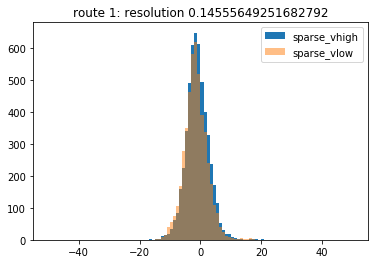

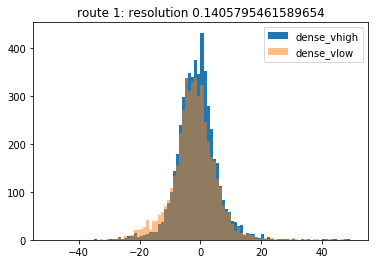

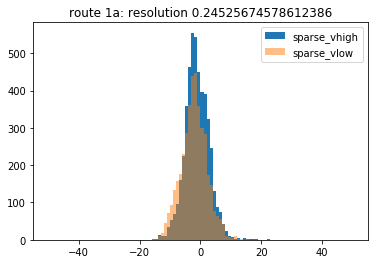

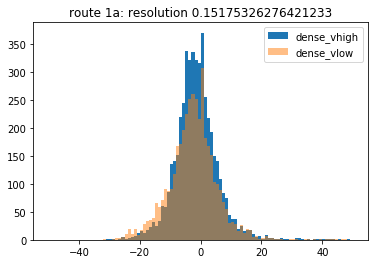

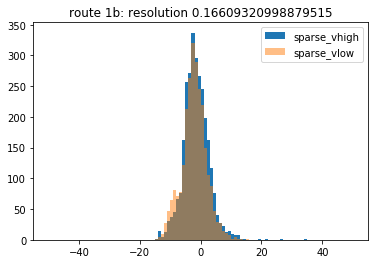

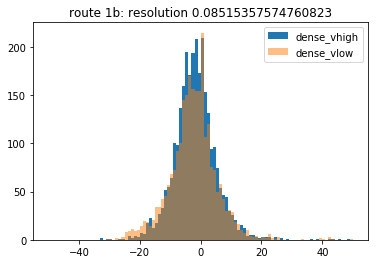

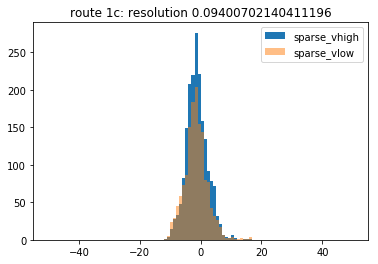

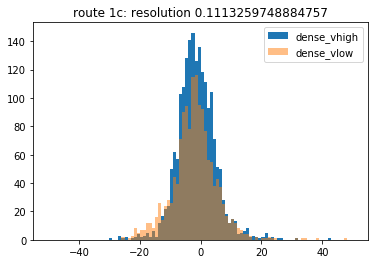

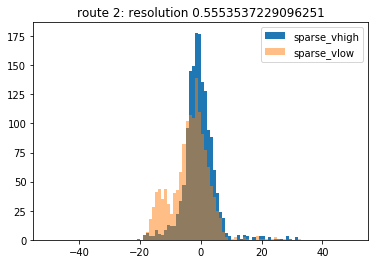

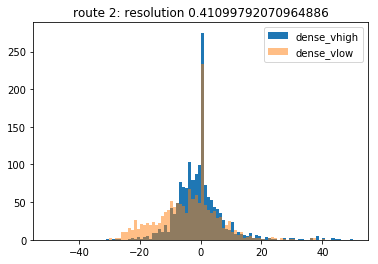

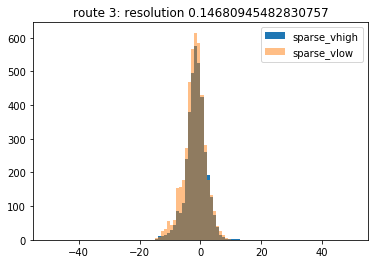

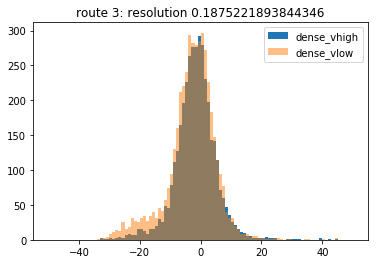

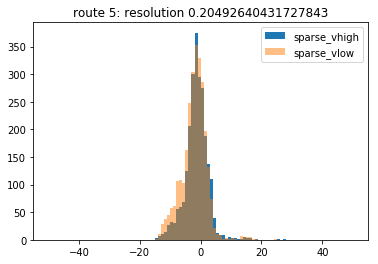

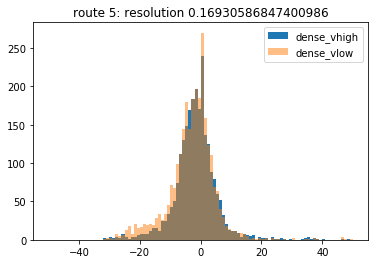

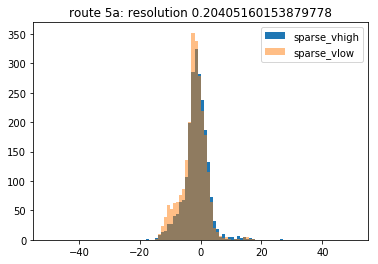

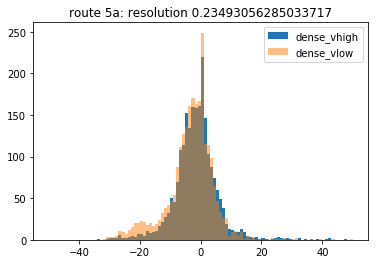

In [188]:
for i in range(len(names)):
    if(freq[i] > 100000):
        plt.hist(sparse_vhigh_data[i], bins=100, range=(-50,50), label="sparse_vhigh")
        plt.hist(sparse_vlow_data[i], bins=100, range=(-50,50), label="sparse_vlow", alpha=0.5);
        plt.legend()
        plt.title(f"route {names[i]}: resolution {(sparse_vhigh_mean[i] - sparse_vlow_mean[i])/np.std(sparse_vhigh_data[i])}")
        plt.show()
        
        plt.hist(dense_vhigh_data[i], bins=100, range=(-50,50), label="dense_vhigh")
        plt.hist(dense_vlow_data[i], bins=100, range=(-50,50), label="dense_vlow", alpha=0.5);
        plt.legend()
        plt.title(f"route {names[i]}: resolution {(dense_vhigh_mean[i] - dense_vlow_mean[i])/np.std(dense_vhigh_data[i])}")
        plt.show()

In [ ]:
(baseline_array_cum, 
 actual_array_cum, 
 baseline_median_array_cum, 
 baseline_pass_count, 
 pass_fraction, 
 baseline_median_pass_count, 
 median_pass_fraction) = calc_baseline_and_actual(test_mask)

In [ ]:
mean_absolute_error(test_target, st_offsets_dense[cut_point:,0,3])

In [ ]:
mean_absolute_error(test_target, offsets_sparse2[cut_point:])

In [ ]:
mean_absolute_error(test_target, [0] * len(test_target))

In [ ]:
# offsets_dense2, _, mean_weights_dense2 = calc_offsets(means, counts, calc_slice(1,8), (1,2), None, 40)

# offsets_dense, _, mean_weights_dense = calc_offsets(means, counts, calc_slice(2,10), (1,2), None, 40)

# offsets_sparse, _, mean_weights_sparse = calc_offsets(means, counts, calc_slice(8,15), (1,2), None, 60)

# offsets_sparse2, _, mean_weights_sparse2 = calc_offsets(means, counts, calc_slice(10,20), (1,2), None, 40)



In [ ]:
# target = se.loc[data_mask, 'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day']

print(f"MAE dense2: {mean_absolute_error(test_target, st_offsets_dense[cut_point:,0,3])}")

print(f"MAE dense2_prev: {mean_absolute_error(test_target, st_offsets_dense[cut_point:,0,2])}")

print(f"MAE dense2_next: {mean_absolute_error(test_target, st_offsets_dense[cut_point:,0,4])}")
      
print(f"MAE sparse2: {mean_absolute_error(test_target, offsets_sparse2[cut_point:])}")
            
print(f"MAE RNN: {mean_absolute_error(test_target, test_y)}")
      
      

In [ ]:
# target = se.loc[data_mask, 'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day']

print(f"RMSE dense2: {np.sqrt(mean_squared_error(test_target, st_offsets_dense[cut_point:,0,3]))}")

print(f"RMSE dense2_prev: {np.sqrt(mean_squared_error(test_target, st_offsets_dense[cut_point:,0,2]))}")

print(f"RMSE dense2_next: {np.sqrt(mean_squared_error(test_target, st_offsets_dense[cut_point:,0,4]))}")
      
print(f"RMSE sparse2: {np.sqrt(mean_squared_error(test_target, offsets_sparse2[cut_point:]))}")
            
print(f"RMSE RNN: {np.sqrt(mean_squared_error(test_target, test_y))}")
      
# print(f"RMSE sparse2: {np.sqrt(mean_squared_error(target, offsets_sparse2))}")
      
      

In [ ]:
data_size

In [ ]:
MAE_baseline = []
MAE_dense2_predict = []
# MAE_dense_predict = []
# MAE_sparse_predict = []
MAE_RNN_predict = []
MAE_sparse2_predict = []

RMSE_baseline = []
RMSE_dense2_predict = []
# RMSE_dense_predict = []
# RMSE_sparse_predict = []
RMSE_RNN_predict = []
RMSE_sparse2_predict = []

freqeuncy = []

halfM = 500000

x = np.array(range(20))*10

# target = se.loc[data_mask, 'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'].values[cut_point:]
baseline = np.zeros(data_size)

for i in x:


    full_mask = (bus_counts>i) & (bus_counts<i+10)
    
    freqeuncy.append(np.count_nonzero(full_mask))
    
    MAE_baseline.append(mean_absolute_error(target[full_mask], baseline[full_mask]))
    
    MAE_dense2_predict.append(mean_absolute_error(target[full_mask], offsets_dense2[full_mask]))
        
#     MAE_dense_predict.append(mean_absolute_error(target[full_mask], offsets_dense[full_mask]))
    
#     MAE_sparse_predict.append(mean_absolute_error(target[full_mask], offsets_sparse[full_mask]))

#     MAE_RNN_predict.append(mean_absolute_error(test_target[full_mask], test_y[full_mask]))
    
    MAE_sparse2_predict.append(mean_absolute_error(target[full_mask], offsets_sparse2[full_mask]))
    
    RMSE_baseline.append(mean_squared_error(target[full_mask], baseline[full_mask]))
    
    RMSE_dense2_predict.append(mean_squared_error(target[full_mask], offsets_dense2[full_mask]))
        
#     RMSE_dense_predict.append(mean_squared_error(target[full_mask], offsets_dense[full_mask]))
    
#     RMSE_sparse_predict.append(mean_squared_error(target[full_mask], offsets_sparse[full_mask]))

#     RMSE_RNN_predict.append(mean_squared_error(test_target[full_mask], test_y[full_mask]))
    
    RMSE_sparse2_predict.append(mean_squared_error(target[full_mask], offsets_sparse2[full_mask]))
    

In [ ]:
MAE_baseline = []
MAE_dense2_predict = []
# MAE_dense_predict = []
# MAE_sparse_predict = []
MAE_RNN_predict = []
MAE_sparse2_predict = []

RMSE_baseline = []
RMSE_dense2_predict = []
# RMSE_dense_predict = []
# RMSE_sparse_predict = []
RMSE_RNN_predict = []
RMSE_sparse2_predict = []



freqeuncy = []

x = np.array(range(20))*10

# target = se.loc[data_mask, 'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'].values[cut_point:]
baseline = np.zeros(data_size)[cut_point:]

for i in x:


    full_mask = (bus_counts>i)[cut_point:] & (bus_counts<i+10)[cut_point:]
    
    freqeuncy.append(np.count_nonzero(full_mask))
    
    MAE_baseline.append(mean_absolute_error(test_target[full_mask], baseline[full_mask]))
    
    MAE_dense2_predict.append(mean_absolute_error(test_target[full_mask], st_offsets_dense[cut_point:,0,3][full_mask]))
        
#     MAE_dense_predict.append(mean_absolute_error(target[full_mask], offsets_dense[full_mask]))
    
#     MAE_sparse_predict.append(mean_absolute_error(target[full_mask], offsets_sparse[full_mask]))

    MAE_RNN_predict.append(mean_absolute_error(test_target[full_mask], test_y[full_mask]))
    
    MAE_sparse2_predict.append(mean_absolute_error(test_target[full_mask], offsets_sparse2[cut_point:][full_mask]))
    
    RMSE_baseline.append(mean_squared_error(test_target[full_mask], baseline[full_mask]))
    
    RMSE_dense2_predict.append(mean_squared_error(test_target[full_mask], st_offsets_dense[cut_point:,0,3][full_mask]))
        
#     RMSE_dense_predict.append(mean_squared_error(target[full_mask], offsets_dense[full_mask]))
    
#     RMSE_sparse_predict.append(mean_squared_error(target[full_mask], offsets_sparse[full_mask]))

    RMSE_RNN_predict.append(mean_squared_error(test_target[full_mask], test_y[full_mask]))
    
    RMSE_sparse2_predict.append(mean_squared_error(test_target[full_mask], offsets_sparse2[cut_point:][full_mask]))
    

In [ ]:
# MAE_dense_predict = np.array(MAE_dense_predict)
MAE_dense2_predict = np.array(MAE_dense2_predict)
MAE_baseline = np.array(MAE_baseline)
# MAE_sparse_predict = np.array(MAE_sparse_predict)
MAE_sparse2_predict = np.array(MAE_sparse2_predict)
MAE_RNN_predict = np.array(MAE_RNN_predict)


# plt.plot(x, percentages_baseline, label="baseline")
# plt.plot(x, MAE_dense_predict-MAE_baseline, label="predict (d)")
plt.plot(x, MAE_dense2_predict-MAE_baseline, label="predict (v_d)")
# plt.plot(x, MAE_sparse_predict-MAE_baseline, label="predict (s)")
plt.plot(x, MAE_sparse2_predict-MAE_baseline, label="predict (v_s)")
plt.plot(x, MAE_RNN_predict-MAE_baseline, label="RNN")

plt.xlabel("Density of data points close to event")
plt.ylabel("Change in MAE of events compared to baseline")
plt.legend(loc=1)
# plt.ylim(35,47)

ax = plt.gca()

ax2 = ax.twinx()
 
ax2.plot(x, freqeuncy, c="grey", ls=":")
# ax2.set_yscale("log")
ax2.set_ylabel("Frequency")
plt.title("How prediction accuracy varies with data density\n(just using means)")
# plt.savefig("accuracy vs density_2m_forward.pdf")
plt.show()



In [ ]:
# RMSE_dense_predict = np.array(RMSE_dense_predict)
RMSE_dense2_predict = np.array(RMSE_dense2_predict)
RMSE_baseline = np.array(RMSE_baseline)
# RMSE_sparse_predict = np.array(RMSE_sparse_predict)
RMSE_sparse2_predict = np.array(RMSE_sparse2_predict)
RMSE_RNN_predict = np.array(RMSE_RNN_predict)


# plt.plot(x, percentages_baseline, label="mean")
# plt.plot(x, RMSE_dense_predict-RMSE_baseline, label="predict (d)")
plt.plot(x, RMSE_dense2_predict-RMSE_baseline, label="predict (v_d)")
# plt.plot(x, RMSE_sparse_predict-RMSE_baseline, label="predict (s)")
plt.plot(x, RMSE_sparse2_predict-RMSE_baseline, label="predict (v_s)")
plt.plot(x, RMSE_RNN_predict-RMSE_baseline, label="RNN")
plt.xlabel("Density of data points close to event")
plt.ylabel("Change in RMSE of events compared to baseline")
plt.legend(loc=1)
# plt.ylim(35,47)

ax = plt.gca()

ax2 = ax.twinx()
 
ax2.plot(x, freqeuncy, c="grey", ls=":")
ax2.set_ylabel("Frequency")
plt.title("How prediction accuracy varies with data density\n(just using means)")
# plt.savefig("accuracy vs density_2m_forward.pdf")
plt.show()



In [ ]:
plt.hist(test_target, bins=100, range=(-100,100), label="target");
plt.hist(test_y, bins=100, range=(-100,100), alpha=0.5, label="RNN");
# plt.hist(st_offsets_dense[cut_point:,0,3], bins=100, range=(-100,100), alpha=0.5, label="Dense");
# plt.hist(offsets_sparse2[cut_point:], bins=100, range=(-100,100), alpha=0.5, label="Sparse");
plt.legend()
plt.yscale("log")


In [ ]:
predict_array_RNN_cum, _, pass_fraction = calc_prediction_cum_journeys(None, offsets=test_y.squeeze(), baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, calc_mask=test_mask)


In [ ]:
plt.plot(make_accuracy_matrix_minutes(predict_array_RNN_cum, actual_array_cum)[0][0,:], label="RNN")
plt.plot(make_accuracy_matrix_minutes(baseline_array_cum, actual_array_cum)[0][0,:], label="means")
plt.plot(make_accuracy_matrix_minutes(baseline_median_array_cum, actual_array_cum)[0][0,:], label="medians")
plt.plot(make_accuracy_matrix_minutes((baseline_median_array_cum + baseline_array_cum)/2, actual_array_cum)[0][0,:], label="mean of aves")
plt.xlim(0,25)
plt.legend()
plt.show()

In [ ]:
median_pass_fraction

In [ ]:
def percent_in_x_percent(predict, actual, threshold):
    
    if np.count_nonzero(~np.isnan(actual)) == 0:
        return 0, 0
    
    threshold = threshold/100
    
    mask = (~np.isnan(predict) & ~np.isnan(actual))
    
    pass_count = np.count_nonzero((predict[mask] < actual[mask] * (1 + threshold)) & (predict[mask] > actual[mask] * (1-threshold)))
    
    over_count = np.count_nonzero(predict[mask] > actual[mask] * (1+threshold))
    
    under_count = np.count_nonzero(predict[mask] < actual[mask] * (1-threshold))
    
    pass_percent = pass_count/np.count_nonzero(mask) * 100
    
    if over_count + under_count == 0:
        drift = 0.5
    else:
        drift = over_count / (over_count + under_count)
    
    return pass_percent, drift

def make_accuracy_matrix_minutes(predict, actual, max_threshold = 50):

    actual_ints = np.array(actual/60).astype(int)
    
    rows = int(max_threshold/10)
    
    max_a = np.nanmax(actual)/60

    accuracies_table = np.empty((rows, int(max_a)))
    drift_table = np.empty((rows, int(max_a)))
    frequency = np.empty(int(max_a))

    for i in range(int(max_a)):
        print(".", end="", flush=True)
        mask = (actual_ints == i)
        
        frequency[i] = np.count_nonzero(mask)
        
        for j in range(1, rows+1):
            accuracy, drift = percent_in_x_percent(predict[mask], actual[mask], j * 10)
            accuracies_table[j-1,i] = accuracy
            drift_table[j-1, i] = drift

    return accuracies_table, frequency, drift_table

def show_accuracy_minutes(predict, actual, title):
    results, frequency, drift = make_accuracy_matrix_minutes(predict, actual)
    
    for i in range(results.shape[0]):
        plt.plot(results[i,:], label=f"{(i+1)*10}%")
        
        
    plt.xlabel("minutes ahead")
    plt.ylabel("percentage within threshold")
    plt.legend()
    plt.title(title)
    plt.xlim(0,20)
    plt.ylim(0,100)
    plt.gca().yaxis.grid(True, linewidth="0.2")
    
    ax = plt.gca()
    
    ax2 = ax.twinx()
    ax2.plot(drift[0,:], label="fraction over", linestyle=":")
    ax2.set_ylim(0,1)
   
    plt.show()

In [ ]:
# From: https://stackoverflow.com/questions/51597849/padding-a-numpy-array-with-offsets-for-each-data-column

def create_padded_array(a, row_start, n_rows):
    r = np.arange(n_rows)[:,None]
    row_start = np.asarray(row_start)
    mask = (r >= row_start) & (r < row_start+a.shape[0])

    out = np.zeros(mask.shape, dtype=a.dtype)
    out[:] = np.nan
    out.T[mask.T] = a.ravel('F')
    return out   

def create_triangle(input_array, max_width=70):
    
    filled_values = np.empty((input_array.shape[0],70)).astype(float)
    
    filled_values[:] = input_array[:,None]
    
    return create_padded_array(filled_values, list(range(70)), input_array.shape[0]+71)[:input_array.shape[0],:]
    
    
    

In [ ]:
def calc_baseline_and_actual(calc_mask):
    
    if len(calc_mask) == len(data_mask):
        se_min = se[data_mask].copy()
    else:
        se_min = se[data_mask][calc_mask].copy()
    
    baseline_array = np.empty((se_min.shape[0],70)).astype(float)
    baseline_array[:] = np.nan
    
    actual_array = np.empty((se_min.shape[0],70)).astype(float)
    actual_array[:] = np.nan
    
    baseline_median_array = np.empty((se_min.shape[0],70)).astype(float)
    baseline_median_array[:] = np.nan
    
    se_min = se_min.reset_index(drop=True)
    
    runs = se_min.groupby(['date','workid'])
    
    actual_index = se_min.columns.get_loc("segment_duration")
    baseline_index = se_min.columns.get_loc("mean_durations_by_segment_code_and_hour_and_day")
    baseline_median_index = se_min.columns.get_loc("median_durations_by_segment_code_and_hour_and_day")

    for name, run in runs:
        run = run.sort_values("actualArrival")
        
        baseline_array[run.index,:] = create_triangle(run.iloc[:, baseline_index])
        actual_array[run.index,:] = create_triangle(run.iloc[:, actual_index])
        baseline_median_array[run.index,:] = create_triangle(run.iloc[:, baseline_median_index])

#         run_length = len(run)

#         for i in range(min([run_length, 70])):
 
#             baseline_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, baseline_index]

#             actual_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, actual_index]
            
    baseline_array_cum = np.cumsum(baseline_array, axis=1)
    actual_array_cum = np.cumsum(actual_array, axis=1)
    baseline_median_array_cum = np.cumsum(baseline_median_array, axis=1)
    
    actual_array_cum = np.clip(actual_array_cum, 0, 2*60*60)
    
    first_20mins_mask = actual_array_cum < 20*60
    
    baseline_pass_count = np.count_nonzero((baseline_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    pass_fraction = baseline_pass_count/np.count_nonzero(first_20mins_mask)
    
    baseline_median_pass_count = np.count_nonzero((baseline_median_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_median_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    median_pass_fraction = baseline_median_pass_count/np.count_nonzero(first_20mins_mask)
    
    return baseline_array_cum, actual_array_cum, baseline_median_array_cum, baseline_pass_count, pass_fraction, baseline_median_pass_count, median_pass_fraction


In [ ]:
def calc_prediction_cum_journeys(column_name, offsets, baseline_array_cum, actual_array_cum, calc_mask):
    
    if len(calc_mask) == len(data_mask):
        se_min = se[data_mask].copy()
    else:
        se_min = se[data_mask][calc_mask].copy()
    
    if column_name is not None:
        se_min['prediction'] = se_min['mean_durations_by_segment_code_and_hour_and_day'] * (1 + (se_min[column_name]/100))
    
    if offsets is not None:
        se_min['prediction'] = se_min['mean_durations_by_segment_code_and_hour_and_day'] * (1 + (offsets.squeeze()/100))
    
    predict_array = np.empty((se_min.shape[0],70)).astype(float)
    predict_array[:] = np.nan
    
    se_min = se_min.reset_index(drop=True)
    
    runs = se_min.groupby(['date','workid'])
    
    prediction_index = se_min.columns.get_loc("prediction")
    
    for name, run in runs:
        run = run.sort_values("actualArrival")
        
        predict_array[run.index,:] = create_triangle(run.iloc[:, prediction_index])

#         run_length = len(run)

#         for i in range(min([run_length, 70])):

#             predict_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, prediction_index]
            
    predict_array_cum = np.cumsum(predict_array, axis=1)
    
    first_20mins_mask = actual_array_cum < 20*60
    
    baseline_pass_count = np.count_nonzero((baseline_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    
    pass_count = np.count_nonzero((predict_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (predict_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    pass_fraction = pass_count/np.count_nonzero(first_20mins_mask)
        
    print(f"Approximately {(pass_count - baseline_pass_count)/baseline_pass_count*100:0.2f}% improvment on baseline")
    
    print(f"Approximately {pass_fraction*100:0.2f}% are in 10%")
    
    return predict_array_cum, pass_count, pass_fraction
    